In [1]:
# Imports
import torch
import numpy as np
import pandas as pd
from torch import nn
import torch.optim as optim
from tqdm.auto import trange
from itertools import product
import matplotlib.pyplot as plt
from typing import Callable, List, Optional, Tuple
from torch.utils.data import DataLoader, TensorDataset
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score, precision_score, recall_score

In [2]:
data_path = "../data/filtered_weather_data.csv"
data = pd.read_csv(data_path, parse_dates=['Formatted Date'], index_col='Formatted Date')

data.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Temperature (K),Hour,Month
Formatted Date,,,,,,,,,,,,,
2006-01-01 00:00:00+00:00,Mostly Cloudy,rain,1.161111,-3.238889,0.85,16.6152,139.0,9.9015,1016.15,Mostly cloudy throughout the day.,274.311111,0,1
2006-01-01 06:00:00+00:00,Mostly Cloudy,rain,2.072222,-3.272222,0.81,25.4219,136.0,10.0303,1013.24,Mostly cloudy throughout the day.,275.222222,6,1
2006-01-01 12:00:00+00:00,Mostly Cloudy,rain,6.205556,2.238889,0.76,23.4094,141.0,10.3523,1011.18,Mostly cloudy throughout the day.,279.355556,12,1
2006-01-01 18:00:00+00:00,Overcast,rain,5.472222,1.100000,0.83,25.4058,145.0,10.9158,1009.55,Mostly cloudy throughout the day.,278.622222,18,1
2006-01-02 00:00:00+00:00,Overcast,rain,2.350000,-1.550000,0.91,15.2950,221.0,5.3130,1014.72,Overcast throughout the day.,275.500000,0,1


In [3]:
data.shape

(16072, 13)

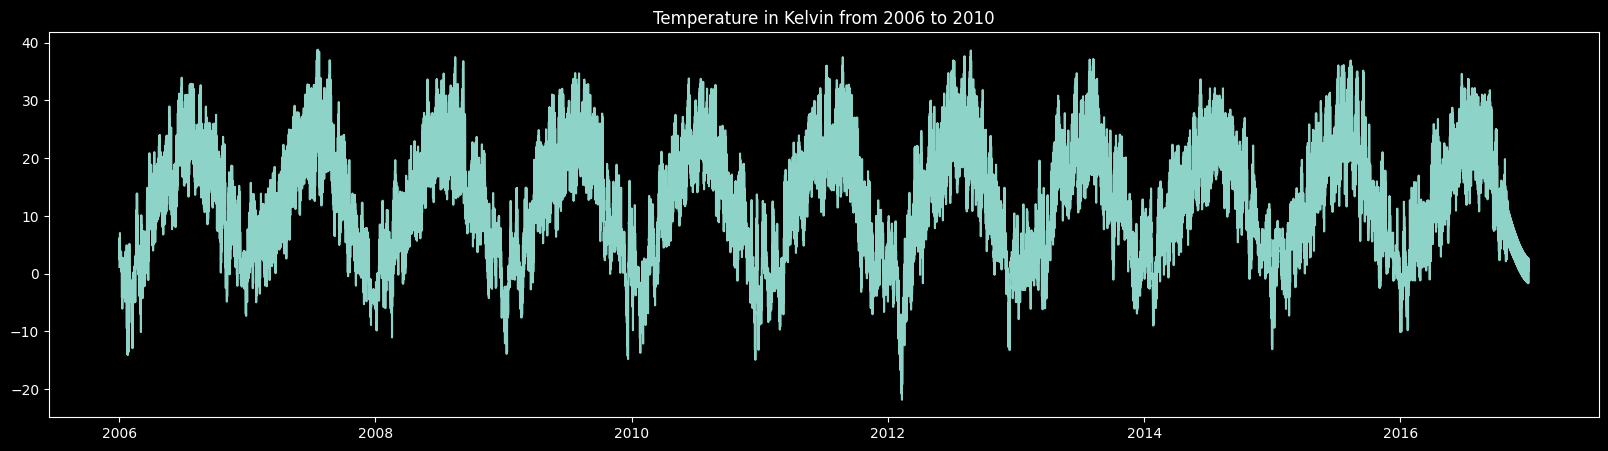

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(data.index.values, data['Temperature (C)'].values)
plt.title('Temperature in Kelvin from 2006 to 2010')
plt.show()

In [5]:
features = ['Temperature (C)', 'Hour', 'Month']
data = data[features]
data.head()

,Temperature (C),Hour,Month
Formatted Date,,,
2006-01-01 00:00:00+00:00,1.161111,0,1
2006-01-01 06:00:00+00:00,2.072222,6,1
2006-01-01 12:00:00+00:00,6.205556,12,1
2006-01-01 18:00:00+00:00,5.472222,18,1
2006-01-02 00:00:00+00:00,2.350000,0,1


In [6]:
data.shape

(16072, 3)

In [7]:
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

### Window size można by dodać do optymalizacji hiperparametrów

In [8]:
def create_features(df, window_size=4):
    df_mod = df.copy()
    for offset in range(1, window_size + 1):
        df_mod.loc[:, f'Temperature_shift_{offset}'] = df_mod.loc[:, 'Temperature (C)'].shift(offset)
    return df_mod.dropna()  # Usunięcie wierszy z NaN wynikających z przesunięcia

train_data = create_features(train_data, window_size=4) # okno czasowe = 4 pomiary co 6h to 24h
test_data = create_features(test_data, window_size=4)

train_data.head()

,Temperature (C),Hour,Month,Temperature_shift_1,Temperature_shift_2,Temperature_shift_3,Temperature_shift_4
Formatted Date,,,,,,,
2006-01-02 00:00:00+00:00,2.350000,0,1,5.472222,6.205556,2.072222,1.161111
2006-01-02 06:00:00+00:00,6.733333,6,1,2.350000,5.472222,6.205556,2.072222
2006-01-02 12:00:00+00:00,7.044444,12,1,6.733333,2.350000,5.472222,6.205556
2006-01-02 18:00:00+00:00,3.944444,18,1,7.044444,6.733333,2.350000,5.472222
2006-01-03 00:00:00+00:00,1.733333,0,1,3.944444,7.044444,6.733333,2.350000


In [9]:
scaler = StandardScaler()

feature_cols = [col for col in train_data.columns if 'shift' in col]

X_train = scaler.fit_transform(train_data[feature_cols])
y_train = train_data['Temperature (C)']

X_test = scaler.transform(test_data[feature_cols])
y_test = test_data['Temperature (C)']

In [10]:
num_bins = 10  # Liczba przedziałów/kategorii

train_data['temp_category'] = pd.cut(train_data['Temperature (C)'], bins=num_bins, labels=False)
test_data['temp_category'] = pd.cut(test_data['Temperature (C)'], bins=num_bins, labels=False)

y_train = train_data['temp_category'].values
y_test = test_data['temp_category'].values

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.long).unsqueeze(1))
test_dataset  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                              torch.tensor(y_test, dtype=torch.long).unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CRF z labów

In [11]:
DEFAULT_EPOCHS = 25 
DEFAULT_BATCH = 200

In [12]:
class CRF(nn.Module):
    """
    Linear-chain Conditional Random Field (CRF).

    based on: https://github.com/mtreviso/linear-chain-crf/blob/master/crf_vectorized.py

    Args:
        nb_labels (int): number of labels in your dataset.
    """

    def __init__(self, nb_labels):
        super().__init__()

        self.nb_labels = nb_labels
        self.PAD_ID = -1

        self.transitions = nn.Parameter(
            torch.empty(self.nb_labels + 1, self.nb_labels + 1)
        )
        nn.init.uniform_(self.transitions, -0.1, 0.1)
        self.transitions.data[self.PAD_ID, :] = -10000.0
        self.transitions.data[:, self.PAD_ID] = -10000.0

    def forward(self, x, mask=None):
        """Select best path for given data."""
        return self.decode(x, mask=mask)

    def log_likelihood(self, emissions, labels, mask=None):
        """Compute the probability of a sequence of labels given a sequence of
        emissions scores.
        Args:
            emissions (torch.Tensor): Sequence of emissions for each label.
                Shape of (batch_size, seq_len, nb_labels).
            labels (torch.LongTensor): Sequence of labels.
                Shape of (batch_size, seq_len).
            mask (torch.FloatTensor, optional): Tensor representing valid positions.
                If None, all positions are considered valid.
                Shape of (batch_size, seq_len).
        Returns:
            torch.Tensor: the log-likelihoods for each sequence in the batch.
                Shape of (batch_size,)
        """
        if mask is None:
            mask = torch.ones(emissions.shape[:2], dtype=torch.float)

        scores = self._compute_scores(emissions, labels, mask=mask)
        partition = self._compute_log_partition(emissions, mask=mask)
        return scores - partition

    def decode(self, emissions, mask=None):
        """Find the most probable sequence of labels given the emissions using
        the Viterbi algorithm.
        Args:
            emissions (torch.Tensor): Sequence of emissions for each label.
                Shape (batch_size, seq_len, nb_labels).
            mask (torch.FloatTensor, optional): Tensor representing valid positions.
                If None, all positions are considered valid.
                Shape (batch_size, seq_len).
        Returns:
            torch.Tensor: the viterbi score for the for each batch.
                Shape of (batch_size,)
            list of lists: the best viterbi sequence of labels for each batch.
        """
        if mask is None:
            mask = torch.ones(emissions.shape[:2], dtype=torch.float)

        scores, sequences = self._viterbi_decode(emissions, mask)
        return scores, sequences

    def _compute_scores(self, emissions, labels, mask):
        """Compute the scores for a given batch of emissions with their labels.
        Args:
            emissions (torch.Tensor): (batch_size, seq_len, nb_labels)
            labels (Torch.LongTensor): (batch_size, seq_len)
            mask (Torch.FloatTensor): (batch_size, seq_len)
        Returns:
            torch.Tensor: Scores for each batch.
                Shape of (batch_size,)
        """
        batch_size, seq_length = labels.shape
        scores = torch.zeros(batch_size)

        current = labels[:, 0]

        # add the [unary] emission scores for the first labels for each batch
        # for all batches, the first label, see the correspondent emissions
        # for the first labels (which is a list of ids):
        # emissions[:, 0, [label_1, label_2, ..., label_nblabels]]
        scores += emissions[:, 0].gather(1, current.unsqueeze(1)).squeeze()

        # now lets do this for each remaining labels
        for i in range(1, seq_length):
            # we could: iterate over batches, check if we reached a mask symbol
            # and stop the iteration, but vecotrizing is faster,
            # so instead we perform an element-wise multiplication
            is_valid = mask[:, i].int()

            previous = current
            current = labels[:, i]

            # calculate emission and transition scores as we did before
            e_scores = emissions[:, i].gather(1, current.unsqueeze(1)).squeeze()
            t_scores = self.transitions[previous, current]

            # apply the mask
            e_scores = e_scores * is_valid
            t_scores = t_scores * is_valid

            scores += e_scores + t_scores

        return scores

    def _compute_log_partition(self, emissions, mask):
        """Compute the partition function in log-space using the forward-algorithm.
        Args:
            emissions (torch.Tensor): (batch_size, seq_len, nb_labels)
            mask (Torch.FloatTensor): (batch_size, seq_len)
        Returns:
            torch.Tensor: the partition scores for each batch.
                Shape of (batch_size,)
        """
        batch_size, seq_length, nb_labels = emissions.shape

        alphas = emissions[:, 0]

        for i in range(1, seq_length):
            # (bs, nb_labels) -> (bs, 1, nb_labels)
            e_scores = emissions[:, i].unsqueeze(1)

            # (nb_labels, nb_labels) -> (bs, nb_labels, nb_labels)
            t_scores = self.transitions.unsqueeze(0)

            # (bs, nb_labels)  -> (bs, nb_labels, 1)
            a_scores = alphas.unsqueeze(2)

            scores = e_scores + t_scores + a_scores
            new_alphas = torch.logsumexp(scores, dim=1)

            # set alphas if the mask is valid, otherwise keep the current values
            is_valid = mask[:, i].unsqueeze(-1).int()
            alphas = is_valid * new_alphas + (1 - is_valid) * alphas

        # return a *log* of sums of exps
        return torch.logsumexp(alphas, dim=1)

    def _viterbi_decode(self, emissions, mask):
        """Compute the viterbi algorithm to find the most probable sequence of labels
        given a sequence of emissions.
        Args:
            emissions (torch.Tensor): (batch_size, seq_len, nb_labels)
            mask (Torch.FloatTensor): (batch_size, seq_len)
        Returns:
            torch.Tensor: the viterbi score for the for each batch.
                Shape of (batch_size,)
            torch.Tensor: the best viterbi sequence of labels for each batch
        """
        batch_size, seq_length, nb_labels = emissions.shape

        alphas = emissions[:, 0]

        backpointers = []

        for i in range(1, seq_length):
            # (bs, nb_labels) -> (bs, 1, nb_labels)
            e_scores = emissions[:, i].unsqueeze(1)

            # (nb_labels, nb_labels) -> (bs, nb_labels, nb_labels)
            t_scores = self.transitions.unsqueeze(0)

            # (bs, nb_labels)  -> (bs, nb_labels, 1)
            a_scores = alphas.unsqueeze(2)

            # combine current scores with previous alphas
            scores = e_scores + t_scores + a_scores

            # so far is exactly like the forward algorithm,
            # but now, instead of calculating the logsumexp,
            # we will find the highest score and the label associated with it
            max_scores, max_score_labels = torch.max(scores, dim=1)

            # set alphas if the mask is valid, otherwise keep the current values
            is_valid = mask[:, i].unsqueeze(-1)
            alphas = is_valid * max_scores + (1 - is_valid) * alphas

            # add the max_score_labels for our list of backpointers
            # max_scores has shape (batch_size, nb_labels) so we transpose it to
            # be compatible with our previous loopy version of viterbi
            backpointers.append(max_score_labels.t())

        # get the final most probable score and the final most probable label
        max_final_scores, max_final_labels = torch.max(alphas, dim=1)

        # find the best sequence of labels for each sample in the batch
        best_sequences = []
        emission_lengths = mask.int().sum(dim=1)
        for i in range(batch_size):
            # recover the original sentence length for the i-th sample in the batch
            sample_length = emission_lengths[i].item()

            # recover the max label for the last timestep
            sample_final_label = max_final_labels[i].item()

            # limit the backpointers until the last but one
            # since the last corresponds to the sample_final_label
            sample_backpointers = backpointers[: sample_length - 1]

            # follow the backpointers to build the sequence of labels
            sample_path = self._find_best_path(
                i, sample_final_label, sample_backpointers
            )

            # add this path to the list of best sequences
            best_sequences.append(sample_path)

        return max_final_scores, torch.tensor(best_sequences)

    def _find_best_path(self, sample_id, best_label, backpointers):
        """Auxiliary function to find the best path sequence for a specific sample.
        Args:
            sample_id (int): sample index in the range [0, batch_size)
            best_label (int): label which maximizes the final score
            backpointers (list of lists of tensors): list of pointers with
            shape (seq_len_i-1, nb_labels, batch_size) where seq_len_i
            represents the length of the ith sample in the batch
        Returns:
            list of ints: a list of label indexes representing the bast path
        """
        # add the final best_label to our best path
        best_path = [best_label]

        # traverse the backpointers in backwards
        for backpointers_t in reversed(backpointers):
            # recover the best_label at this timestep
            best_label = backpointers_t[best_label][sample_id].item()
            best_path.append(best_label)

        return best_path[::-1]

In [13]:
class SequenceClassifier(nn.Module):
    """Helper class for implementing sequence classifier."""

    def __init__(self, nb_labels: int, x_size: int):
        """
        :param nb_labels: number of labels in the target (shape of the output layer)
        :param x_size: size of x input to determin first layer size
        """
        super().__init__()
        self.nb_labels = nb_labels
        self.x_size = x_size


In [14]:
class MLPCRFClassifier(SequenceClassifier):
    def __init__(self, hidden_sizes: Optional[List[int]] = None, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Inicjalizacja CRF z dodatkową etykietą dla paddingu
        self.crf = CRF(self.nb_labels + 1)

        # Warstwy MLP
        hidden_sizes = [self.x_size, *(hidden_sizes or [])]
        self.mlp = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(hidden_sizes, hidden_sizes[1:])]
        )
        self.out = nn.Linear(hidden_sizes[-1], self.nb_labels + 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(*x.shape[:2], -1)
        for layer in self.mlp:
            x = F.relu(layer(x))
        emissions = self.out(x)
        return emissions

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        emissions = self.forward(x)
        _, sequence = self.crf.decode(emissions)
        return sequence


In [15]:
def get_mask(X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Get mask for padding by examining contents of the X tensor."""
    pad_id = torch.max(y).int().item()
    flattened_X = X.view(*X.shape[:2], -1)
    mask = (torch.eq(flattened_X, pad_id).sum(-1) != flattened_X.shape[-1]).bool()
    return mask

In [16]:
def train(
    model: SequenceClassifier,
    loss_fn: Callable[
        [torch.Tensor, torch.Tensor, Optional[torch.Tensor], SequenceClassifier],
        torch.Tensor,
    ],
    dataset: Tuple[
        Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]
    ],
    display_info_fn: Callable[
        [torch.Tensor, torch.Tensor, SequenceClassifier, int], None
    ],
    n_epochs: int,
    lr: float = 0.001,
    batch_size: int = 32,
    use_mask: bool = False,
    log_transitions: bool = False
):
    """Training loop.
    
    :param model: SequenceClassifier instance
    :param loss_fn: callable, which receives feature vector and labels,
        ptional mask and model and calculates the loss function
        for training the model
    :param dataset: tuple (X_train, y_train), (X_test, y_test)
        containing train and test dataset
    :param display_info_fn: callable accepting feature vectors, labels,
        together with the model and optional indices to display some
        information on the results of the model (defined along datasets)
    :param n_epochs: number of epochs to use for training
    :param lr: learning rate to be used in Adam optimizer
    :param batch_size: batch_size set for training the model
    :param use_mask: boolean flag whether to look for padding values in data
    :param log_transitions: boolean flag whether to log transitions values
        during training (used for models with CRF)
    :returns: trained model and logging dictionary
    """
    (X_train, y_train), (X_test, y_test) = dataset
    mask = None

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    log = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    transitions = []

    for epoch in trange(n_epochs):
        if epoch == DEFAULT_EPOCHS:
            break
        
        try:
            model.zero_grad()

            # train
            for X, y in train_dataloader:
                if use_mask:
                    mask = get_mask(X, y)

                y_pred = model(X)
                loss = loss_fn(y_pred, y, mask=mask, model=model)
                loss.backward()
                optimizer.step()

                train_loss.append(loss.detach().item())
                with torch.no_grad():
                    train_acc.append(
                        accuracy_score(y.view(-1), model.predict(X).view(-1))
                    )

            # eval
            with torch.no_grad():
                for X, y in test_dataloader:
                    if use_mask:
                        mask = get_mask(X, y)

                    y_pred = model(X)
                    loss = loss_fn(y_pred, y, mask=mask, model=model)

                    test_loss.append(loss.item())
                    test_acc.append(
                        accuracy_score(y.view(-1), model.predict(X).view(-1))
                    )

            # log
            log["train_loss"].append(np.mean(train_loss))
            log["test_loss"].append(np.mean(test_loss))
            log["train_acc"].append(np.mean(train_acc))
            log["test_acc"].append(np.mean(test_acc))
            if log_transitions:
                transitions.append(model.crf.transitions.detach().numpy().copy())
            train_loss = []
            test_loss = []
            train_acc = []
            test_acc = []

        except KeyboardInterrupt:
            break

    pd.DataFrame(log).reset_index().rename(columns={"index": "epoch"}).plot(
        x="epoch",
        y=["train_loss", "test_loss", "train_acc", "test_acc"],
        secondary_y=["train_acc", "test_acc"],
    )

    for _ in range(5):
        display_info_fn(X_test, y_test, model)
    
    if log_transitions:
        log["transitions"] = transitions

    return model, log

In [17]:
def get_midpoints_from_bins(num_bins, data_min, data_max):
    """Oblicza środkowe punkty dla podziału danych na biny."""
    bins = np.linspace(data_min, data_max, num=num_bins + 1)
    mid_points = (bins[:-1] + bins[1:]) / 2
    return mid_points

In [18]:
def visualize_predictions(predicted_temps, actual_temps):
    dates = test_data.index
    
    if not isinstance(predicted_temps, np.ndarray):
        predicted_temps = np.array(predicted_temps)
    if not isinstance(actual_temps, np.ndarray):
        actual_temps = np.array(actual_temps)
    if not isinstance(dates, np.ndarray):
        dates = np.array(dates)

    plt.figure(figsize=(15, 7))  # Ustaw większy rozmiar dla lepszej czytelności
    plt.plot(dates, predicted_temps, label='Predicted Temperatures', color='red', marker='o', linestyle='-', markersize=2)
    plt.plot(dates, actual_temps, label='Actual Temperatures', marker='x', linestyle='-', markersize=2)
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Comparison of Predicted and Actual Temperatures')
    plt.legend()
    plt.gcf().autofmt_xdate()  # Automatycznie formatuje daty na osi X dla lepszej czytelności
    plt.tight_layout()
    plt.show()


In [46]:
def plot_training_history(results, ncols=3, patience=0):
    num_rows = len(results)
    fig, axes = plt.subplots(nrows=num_rows, ncols=ncols, figsize=(20, 5 * num_rows))
    if num_rows == 1:
        axes = [axes]
    if ncols == 1:
        axes = [[ax] for ax in axes]

    for ax, (key, values) in zip(axes, results.items()):
        epochs = range(1, len(values['train_loss']) + 1)
        stop_epoch = None
        if patience > 0:
            num_epochs = len(epochs)
            stop_epoch = num_epochs - patience
            print(f"Early stopping at epoch {stop_epoch}")


        train_loss = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['train_loss']]
        test_loss = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['test_loss']]    
        
        # train_acc = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['train_accuracy']]
        # test_acc = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['test_accuracy']]
        
        train_f1 = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['train_f_score']]
        test_f1 = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['test_f_score']]
        
        ax[0].plot(epochs, train_loss, label='Train Loss')

        ax[0].plot(epochs, test_loss, label='Test Loss')
        ax[0].set_title(f"{key} Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        if stop_epoch:
            ax[0].axvline(x=stop_epoch, linestyle='--', label='Early Stopping')
            ax[0].legend()

        if ncols == 1:
            continue
        
        ax[1].plot(epochs, train_f1, label='train F1')
        ax[1].plot(epochs, test_f1, label='test F1')
        ax[1].set_title(f"{key} F1 Score")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("F1 Score")
        ax[1].legend()

        if stop_epoch:
            ax[1].axvline(x=stop_epoch, linestyle='--', label='Early Stopping')
            ax[1].legend()
        
        mae = [x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in values['mae']]
        ax[2].plot(epochs, mae, label='MAE')
        ax[2].set_title(f"{key} MAE")
        ax[2].set_xlabel("Epoch")
        ax[2].set_ylabel("MAE")
        ax[2].legend()
    
        if stop_epoch:
            ax[2].axvline(x=stop_epoch, linestyle='--', label='Early Stopping')
            ax[2].legend()

    plt.tight_layout()
    plt.show()

# CRF do Temperatury

In [20]:
class TemperatureCRF(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(feature_dim, num_classes)
        self.crf = CRF(num_classes)

    def forward(self, x, mask=None): 
        emissions = self.linear(x)
        if emissions.dim() == 2:  # Zakładając, że seq_length = 1 dla każdego wsadu
            emissions = emissions.unsqueeze(1)  # Dodajemy wymiar seq_length
        return emissions

    def loss(self, emissions, labels, mask=None):
        if labels.dim() == 1:  # Jeśli labels jest jednowymiarowe
            labels = labels.unsqueeze(1)  # Dodajemy wymiar seq_length
        # Dodaj redukcję do skalara
        return -self.crf.log_likelihood(emissions, labels, mask=mask).mean()

    def predict(self, x, mask=None):
        emissions = self.forward(x)
        scores, sequences = self.crf.decode(emissions, mask=mask)
        return sequences

In [52]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, epochs=100, patience=10, plot=True, print_results=True):
    model.train()
    best_test_loss = float('inf')
    no_improve_epochs = 0
    early_stopping = False
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_accuracy': [],
        'test_accuracy': [],
        'train_f_score': [],
        'test_f_score': [],
        'mae': []
    }
    
    mid_points = get_midpoints_from_bins(num_bins, train_data['Temperature (C)'].min(), train_data['Temperature (C)'].max())


    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features, labels in train_loader:
            features = features.float()
            labels = labels.long()

            optimizer.zero_grad()
            emissions = model(features)
            loss = model.loss(emissions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        average_train_loss = total_loss / len(train_loader)
        train_accuracy = accuracy_score(labels, model.predict(features))
        train_f_score = f1_score(labels, model.predict(features), average='weighted')
        history['train_loss'].append(average_train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_f_score'].append(train_f_score)

        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        predictions = []
        actuals = []

        with torch.no_grad():
            for features, labels in test_loader:
                features = features.float()
                labels = labels.long()
                emissions = model(features)
                loss = model.loss(emissions, labels)
                test_loss += loss.item()

                predicted_sequences = model.predict(features)
                predicted_temperatures = mid_points[predicted_sequences]
                actual_temperatures = mid_points[labels]

                predictions.extend(predicted_temperatures)
                actuals.extend(actual_temperatures)
                correct += (predicted_sequences == labels).sum().item()
                total += labels.size(0)

        average_test_loss = test_loss / len(test_loader)
        test_accuracy = correct / total
        mae = mean_absolute_error(actuals, predictions)
        test_f_score = f1_score(labels, predicted_sequences, average='weighted')
        history['test_loss'].append(average_test_loss)
        history['test_accuracy'].append(test_accuracy)
        history['test_f_score'].append(test_f_score)
        history['mae'].append(mae)

        if print_results:
            print(f'Epoch {epoch + 1}: \n\tTrain Loss = {average_train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Train F1 Score = {train_f_score:.4f}, \n\tTest Loss  = {average_test_loss:.4f}, Test Accuracy  = {test_accuracy:.4f}, Test F1 Score  = {test_f_score:.4f}, MAE = {mae:.4f}°C')

        if average_test_loss < best_test_loss:
            best_test_loss = average_test_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                if print_results:
                    print("Early stopping triggered")
                early_stopping = True
                break
            
    if print_results:
        print("\nTraining completed")
    
    if plot:
        plot_training_history({'CRF': history}, patience=patience)
    
    if early_stopping:
        history['train_loss'] = history['train_loss'][:-(patience)]
        history['train_accuracy'] = history['train_accuracy'][:-(patience)]
        history['test_loss'] = history['test_loss'][:-(patience )]
        history['test_accuracy'] = history['test_accuracy'][:-(patience)]
        history['mae'] = history['mae'][:-(patience)]

    if print_results:
        print(f"Test Loss: {best_test_loss:.4f}, Test Accuracy: {history['test_accuracy'][-1]:.4f}, Test F1 Score: {history['test_f_score'][-1]:.4f}")
        print(f"Średni błąd bezwzględny (MAE): {history['mae'][-1]:.2f}°C")
    
    if plot:
        visualize_predictions(predictions, actuals)
    return history

Epoch 1: 
	Train Loss = 2.1386, Train Accuracy = 0.1429, Train F1 Score = 0.1654, 
	Test Loss  = 1.9786, Test Accuracy  = 0.2526, Test F1 Score  = 0.0000, MAE = 6.7514°C
Epoch 2: 
	Train Loss = 1.7406, Train Accuracy = 0.3810, Train F1 Score = 0.2993, 
	Test Loss  = 1.7711, Test Accuracy  = 0.3329, Test F1 Score  = 0.0000, MAE = 5.2400°C
Epoch 3: 
	Train Loss = 1.5768, Train Accuracy = 0.3810, Train F1 Score = 0.2890, 
	Test Loss  = 1.6732, Test Accuracy  = 0.3731, Test F1 Score  = 0.1169, MAE = 4.5928°C
Epoch 4: 
	Train Loss = 1.4825, Train Accuracy = 0.4762, Train F1 Score = 0.4013, 
	Test Loss  = 1.6146, Test Accuracy  = 0.3927, Test F1 Score  = 0.1169, MAE = 4.4041°C
Epoch 5: 
	Train Loss = 1.4157, Train Accuracy = 0.4762, Train F1 Score = 0.4013, 
	Test Loss  = 1.5745, Test Accuracy  = 0.3868, Test F1 Score  = 0.1169, MAE = 4.3739°C
Epoch 6: 
	Train Loss = 1.3646, Train Accuracy = 0.5238, Train F1 Score = 0.4762, 
	Test Loss  = 1.5457, Test Accuracy  = 0.3843, Test F1 Score  = 0.1

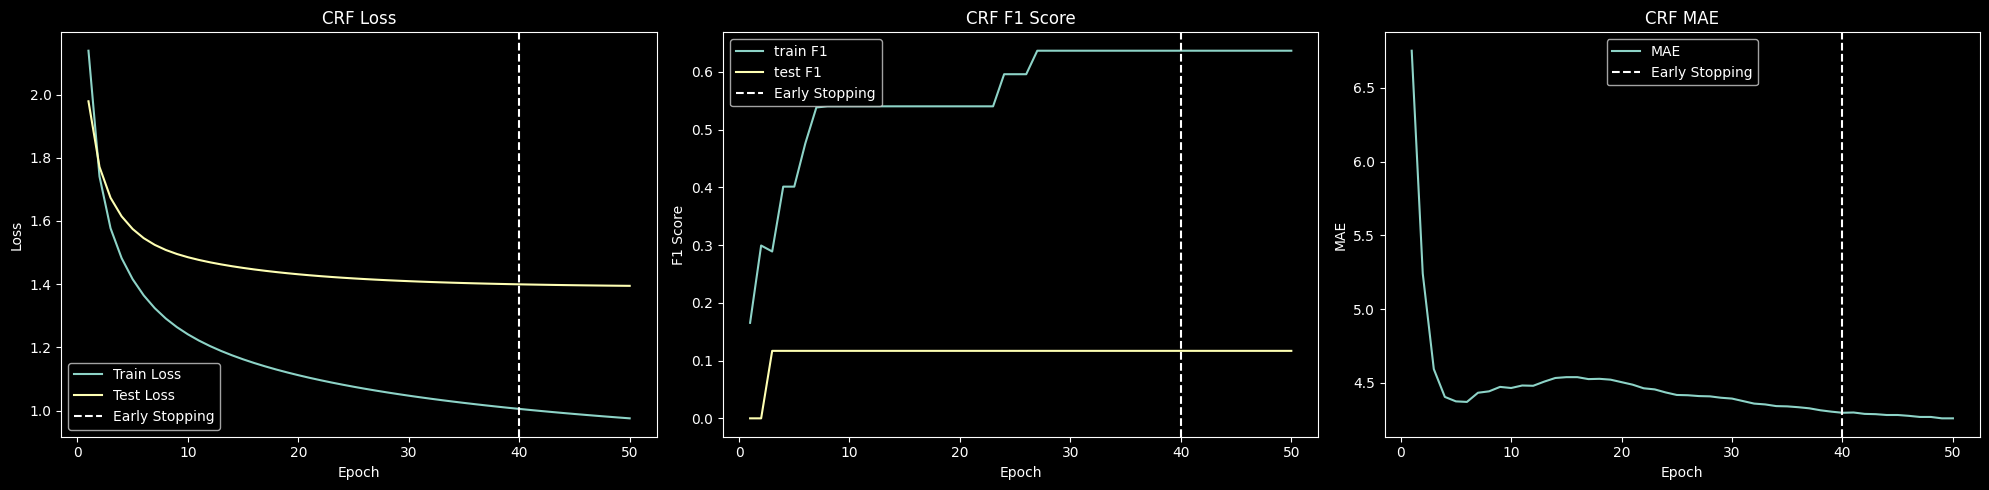

Test Loss: 1.3947, Test Accuracy: 0.3871, Test F1 Score: 0.1169
Średni błąd bezwzględny (MAE): 4.26°C


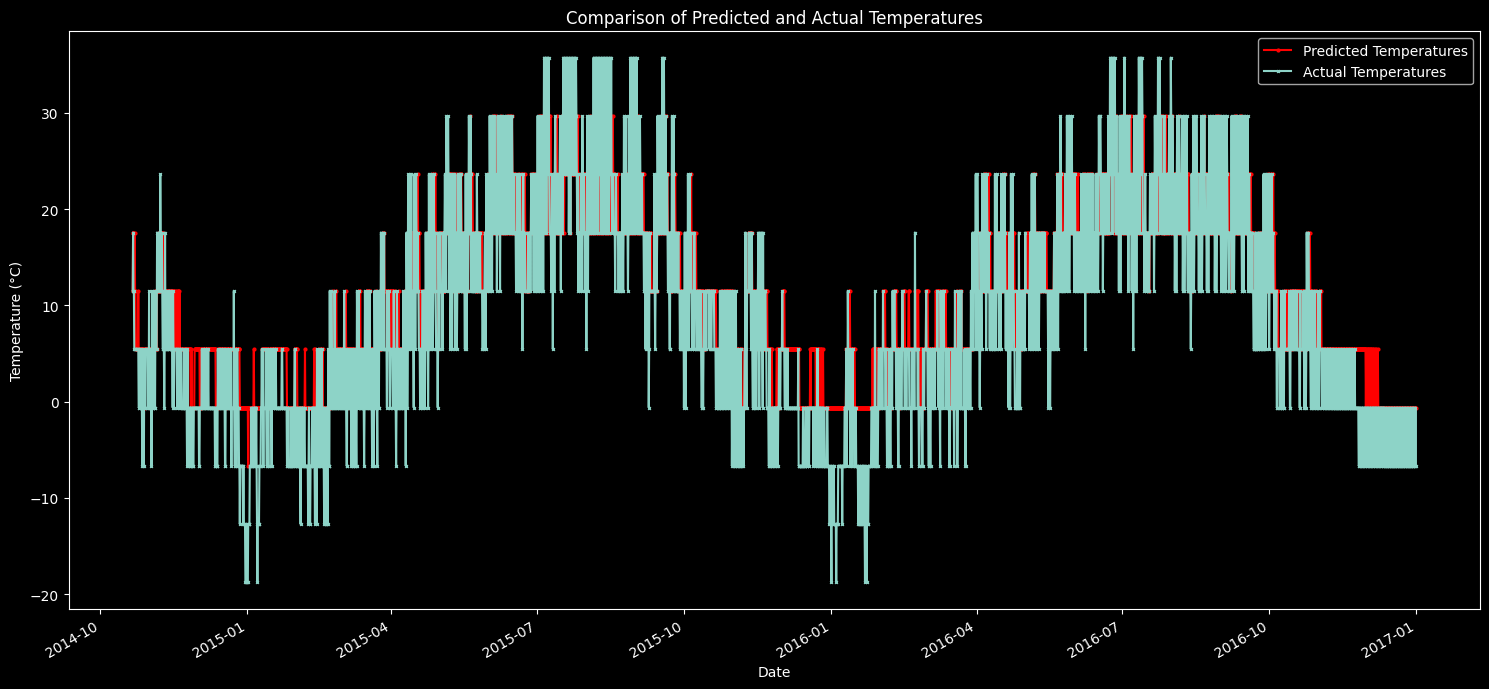

In [53]:
model = TemperatureCRF(feature_dim=X_train.shape[1], num_classes=num_bins)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
history = train_and_evaluate(model, train_loader, test_loader, optimizer, epochs=50)

# Użycie MLP z CRF

In [54]:
class MLPTemperatureCRFClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes, hidden_sizes=None):
        super().__init__()
        self.num_classes = num_classes
        self.hidden_sizes = hidden_sizes if hidden_sizes is not None else [feature_dim, 64, 64]
        
        layers = []
        for in_size, out_size in zip(self.hidden_sizes[:-1], self.hidden_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
        self.mlp = nn.Sequential(*layers)
        
        self.out = nn.Linear(self.hidden_sizes[-1], num_classes)
        
        self.crf = CRF(num_classes)

    def forward(self, x):
        x = self.mlp(x)
        
        # x has at least two dimensions [batch_size, seq_length]
        if x.dim() == 1:
            x = x.unsqueeze(0)

        emissions = self.out(x)
        if emissions.dim() == 2:
            emissions = emissions.unsqueeze(1)
        return emissions

    def predict(self, x, mask=None):
        emissions = self.forward(x)
        _, sequences = self.crf.decode(emissions, mask=mask)
        return sequences

    def loss(self, emissions, labels, mask=None):
        # labels has at least two dimensions [batch_size, seq_length]
        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        return -self.crf.log_likelihood(emissions, labels, mask=mask).mean()

Epoch 1: 
	Train Loss = 1.5902, Train Accuracy = 0.4286, Train F1 Score = 0.5365, 
	Test Loss  = 1.5501, Test Accuracy  = 0.3239, Test F1 Score  = 0.1169, MAE = 4.9116°C
Epoch 2: 
	Train Loss = 1.1333, Train Accuracy = 0.5714, Train F1 Score = 0.5561, 
	Test Loss  = 1.4222, Test Accuracy  = 0.3731, Test F1 Score  = 0.1169, MAE = 4.3399°C
Epoch 3: 
	Train Loss = 1.0494, Train Accuracy = 0.6190, Train F1 Score = 0.6975, 
	Test Loss  = 1.4035, Test Accuracy  = 0.3818, Test F1 Score  = 0.1169, MAE = 4.1908°C
Epoch 4: 
	Train Loss = 1.0085, Train Accuracy = 0.4762, Train F1 Score = 0.6232, 
	Test Loss  = 1.3879, Test Accuracy  = 0.3865, Test F1 Score  = 0.1169, MAE = 4.1908°C
Epoch 5: 
	Train Loss = 0.9805, Train Accuracy = 0.4762, Train F1 Score = 0.6542, 
	Test Loss  = 1.4439, Test Accuracy  = 0.3874, Test F1 Score  = 0.1169, MAE = 4.1569°C
Epoch 6: 
	Train Loss = 0.9597, Train Accuracy = 0.5714, Train F1 Score = 0.4944, 
	Test Loss  = 1.4982, Test Accuracy  = 0.3840, Test F1 Score  = 0.1

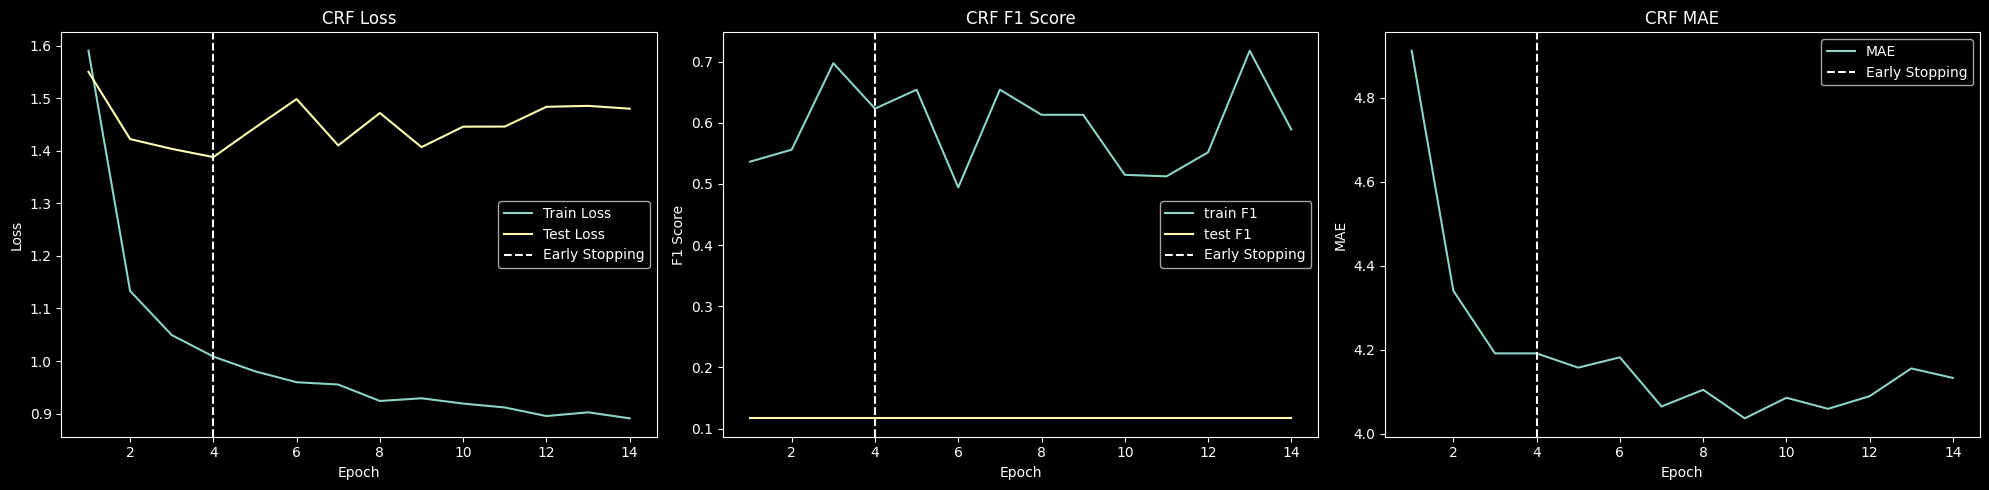

Test Loss: 1.3879, Test Accuracy: 0.3865, Test F1 Score: 0.1169
Średni błąd bezwzględny (MAE): 4.19°C


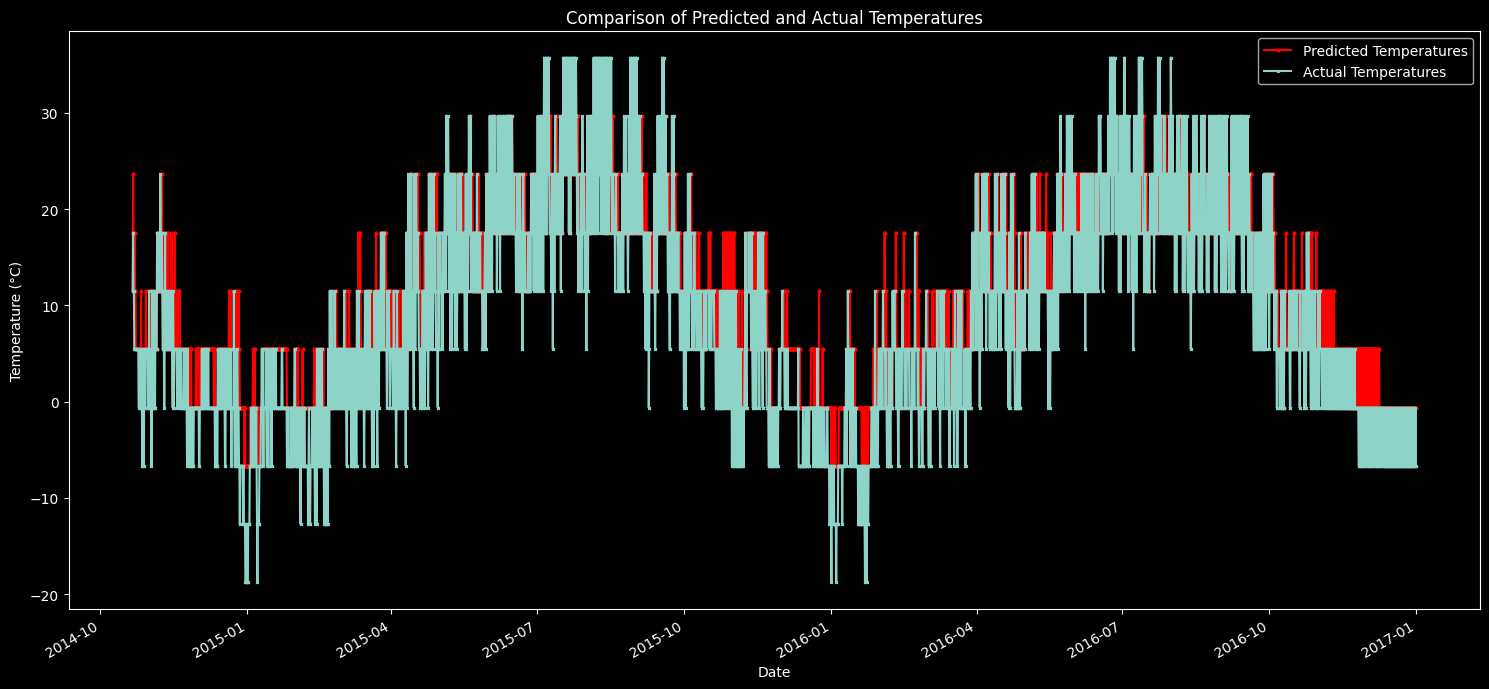

In [55]:
feature_dim = X_train.shape[1]
model = MLPTemperatureCRFClassifier(feature_dim, num_bins)
optimizer = optim.Adam(model.parameters(), lr=0.001)

metrics = train_and_evaluate(model, train_loader, test_loader, optimizer ,epochs=50, patience=10)

In [56]:
def hyperparameter_search_mlp(train_loader, test_loader):
    feature_dim = X_train.shape[1]
    num_classes = num_bins

    hidden_sizes_options = [
        [feature_dim, 32], [feature_dim, 64], [feature_dim, 128],
        [feature_dim, 32, 32], [feature_dim, 64, 64], [feature_dim, 128, 128]
    ]
    lr_options = [0.0001, 0.001, 0.01]
    batch_size_options = [16, 32, 64]

    results = []

    for hidden_sizes, lr, batch_size in product(hidden_sizes_options, lr_options, batch_size_options):
        print(f'Testing configuration: hidden_sizes={hidden_sizes},  lr={lr}, batch_size={batch_size}')
        
        model = MLPTemperatureCRFClassifier(feature_dim, num_classes, hidden_sizes)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        metrics = train_and_evaluate(model, train_loader, test_loader, optimizer, epochs=50, patience=5, plot=False, print_results=False)
        
        results.append({
            'hidden_sizes': hidden_sizes,
            'lr': lr,
            'batch_size': batch_size,
            'train_loss': metrics['train_loss'][-1],
            'train_accuracy': metrics['train_accuracy'][-1],
            'train_f_score': metrics['train_f_score'][-1],
            'test_loss': metrics['test_loss'][-1],
            'test_accuracy': metrics['test_accuracy'][-1],
            'test_f_score': metrics['test_f_score'][-1],
            'mae': metrics['mae'][-1]
        })
        print(f"Test Loss: {metrics['test_loss'][-1]:.4f}, Test Accuracy: {metrics['test_accuracy'][-1]:.4f}, Test F1 Score: {metrics['test_f_score'][-1]:.4f}, MAE: {metrics['mae'][-1]:.2f}")

    results_df = pd.DataFrame(results)
    results_df.to_csv('mlp_hyperparameter_search_results.csv', index=False)
    print("MLP Hyperparameter search results saved to 'mlp_hyperparameter_search_results.csv'")
    return results_df

mlp_results_df = hyperparameter_search_mlp(train_loader, test_loader)


Testing configuration: hidden_sizes=[4, 32],  lr=0.0001, batch_size=16
Test Loss: 1.3761, Test Accuracy: 0.3896, Test F1 Score: 0.1169, MAE: 4.15
Testing configuration: hidden_sizes=[4, 32],  lr=0.0001, batch_size=32
Test Loss: 1.3987, Test Accuracy: 0.4027, Test F1 Score: 0.1169, MAE: 4.08
Testing configuration: hidden_sizes=[4, 32],  lr=0.0001, batch_size=64
Test Loss: 1.4018, Test Accuracy: 0.3952, Test F1 Score: 0.1169, MAE: 4.13
Testing configuration: hidden_sizes=[4, 32],  lr=0.001, batch_size=16
Test Loss: 1.4225, Test Accuracy: 0.3793, Test F1 Score: 0.1169, MAE: 4.29
Testing configuration: hidden_sizes=[4, 32],  lr=0.001, batch_size=32
Test Loss: 1.4358, Test Accuracy: 0.3986, Test F1 Score: 0.1169, MAE: 4.07
Testing configuration: hidden_sizes=[4, 32],  lr=0.001, batch_size=64
Test Loss: 1.4228, Test Accuracy: 0.3890, Test F1 Score: 0.1169, MAE: 4.15
Testing configuration: hidden_sizes=[4, 32],  lr=0.01, batch_size=16
Test Loss: 1.4998, Test Accuracy: 0.3771, Test F1 Score: 0

In [57]:
print("Top 5 configurations for MLP (test loss):")
print(mlp_results_df.nsmallest(5, 'test_loss'))

print("Top 5 configurations for MLP (f1 score):")
print(mlp_results_df.nlargest(5, 'test_f_score'))

print("Top 5 configurations for MLP (MAE):")
print(mlp_results_df.nsmallest(5, 'mae'))

Top 5 configurations for MLP (test loss):
     hidden_sizes      lr  batch_size  train_loss  train_accuracy  \
41    [4, 64, 64]  0.0010          64    0.926688        0.666667   
36    [4, 64, 64]  0.0001          16    1.069973        0.714286   
49  [4, 128, 128]  0.0010          32    0.916248        0.619048   
38    [4, 64, 64]  0.0001          64    1.023261        0.523810   
37    [4, 64, 64]  0.0001          32    1.077050        0.523810   

    train_f_score  test_loss  test_accuracy  test_f_score       mae  
41       0.636735   1.336174       0.412955      0.116883  3.924786  
36       0.697479   1.352868       0.409841      0.116883  4.011584  
49       0.529915   1.354532       0.407038      0.116883  3.934221  
38       0.605042   1.363259       0.415447      0.116883  3.981394  
37       0.653061   1.365458       0.407973      0.116883  4.038001  
Top 5 configurations for MLP (f1 score):
   hidden_sizes    lr  batch_size  train_loss  train_accuracy  train_f_score  \
24

# CRF z LSTM

In [58]:
class LSTMTemperatureCRFClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes, hidden_dim=64, num_layers=1):
        super().__init__()
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Definiowanie warstwy LSTM
        self.lstm = nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True)
        
        # Warstwa w pełni połączona
        self.out = nn.Linear(hidden_dim, num_classes)
        
        self.crf = CRF(num_classes)

    def forward(self, x):
        # Przekształcenie danych wejściowych do formatu [batch_size, seq_length, feature_dim]
        x = x.view(x.size(0), -1, x.size(1))
        lstm_out, _ = self.lstm(x)
        
        # Przetwarzanie wyjścia LSTM przez warstwę w pełni połączoną
        emissions = self.out(lstm_out)
        
        return emissions

    def predict(self, x, mask=None):
        emissions = self.forward(x)
        _, sequences = self.crf.decode(emissions, mask=mask)
        return sequences

    def loss(self, emissions, labels, mask=None):
        # Ensure labels has at least two dimensions [batch_size, seq_length]
        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        return -self.crf.log_likelihood(emissions, labels, mask=mask).mean()


Epoch 1: 
	Train Loss = 1.4472, Train Accuracy = 0.3333, Train F1 Score = 0.3264, 
	Test Loss  = 2.2812, Test Accuracy  = 0.2031, Test F1 Score  = 0.1169, MAE = 7.0986°C
Epoch 2: 
	Train Loss = 1.0143, Train Accuracy = 0.5238, Train F1 Score = 0.4374, 
	Test Loss  = 1.6601, Test Accuracy  = 0.3117, Test F1 Score  = 0.5455, MAE = 4.8437°C
Epoch 3: 
	Train Loss = 0.9172, Train Accuracy = 0.4762, Train F1 Score = 0.3741, 
	Test Loss  = 1.6334, Test Accuracy  = 0.3457, Test F1 Score  = 0.1169, MAE = 4.5229°C
Epoch 4: 
	Train Loss = 0.8794, Train Accuracy = 0.4762, Train F1 Score = 0.3741, 
	Test Loss  = 1.4825, Test Accuracy  = 0.3831, Test F1 Score  = 0.5455, MAE = 4.1927°C
Epoch 5: 
	Train Loss = 0.8592, Train Accuracy = 0.4762, Train F1 Score = 0.3612, 
	Test Loss  = 1.5258, Test Accuracy  = 0.3588, Test F1 Score  = 0.1169, MAE = 4.4701°C
Epoch 6: 
	Train Loss = 0.8355, Train Accuracy = 0.4762, Train F1 Score = 0.3741, 
	Test Loss  = 1.4755, Test Accuracy  = 0.3775, Test F1 Score  = 0.1

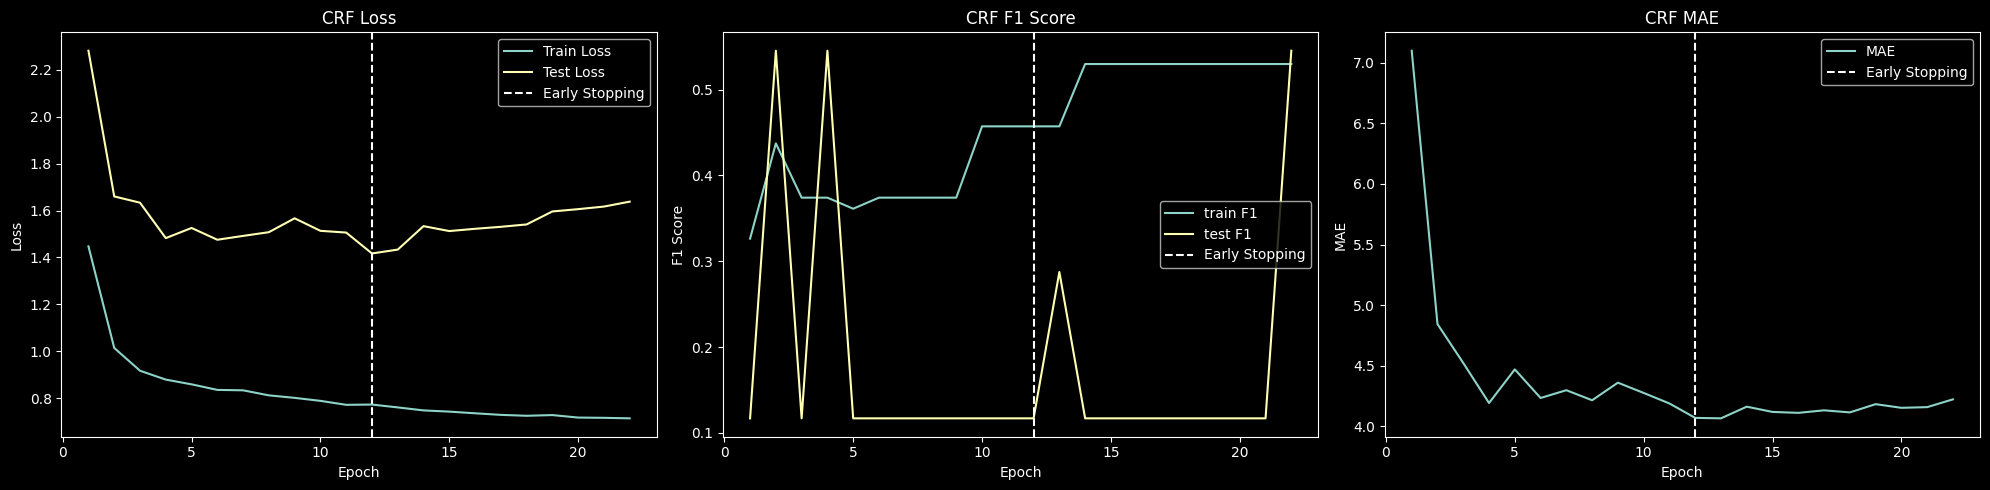

Test Loss: 1.4170, Test Accuracy: 0.3971, Test F1 Score: 0.5455
Średni błąd bezwzględny (MAE): 4.07°C


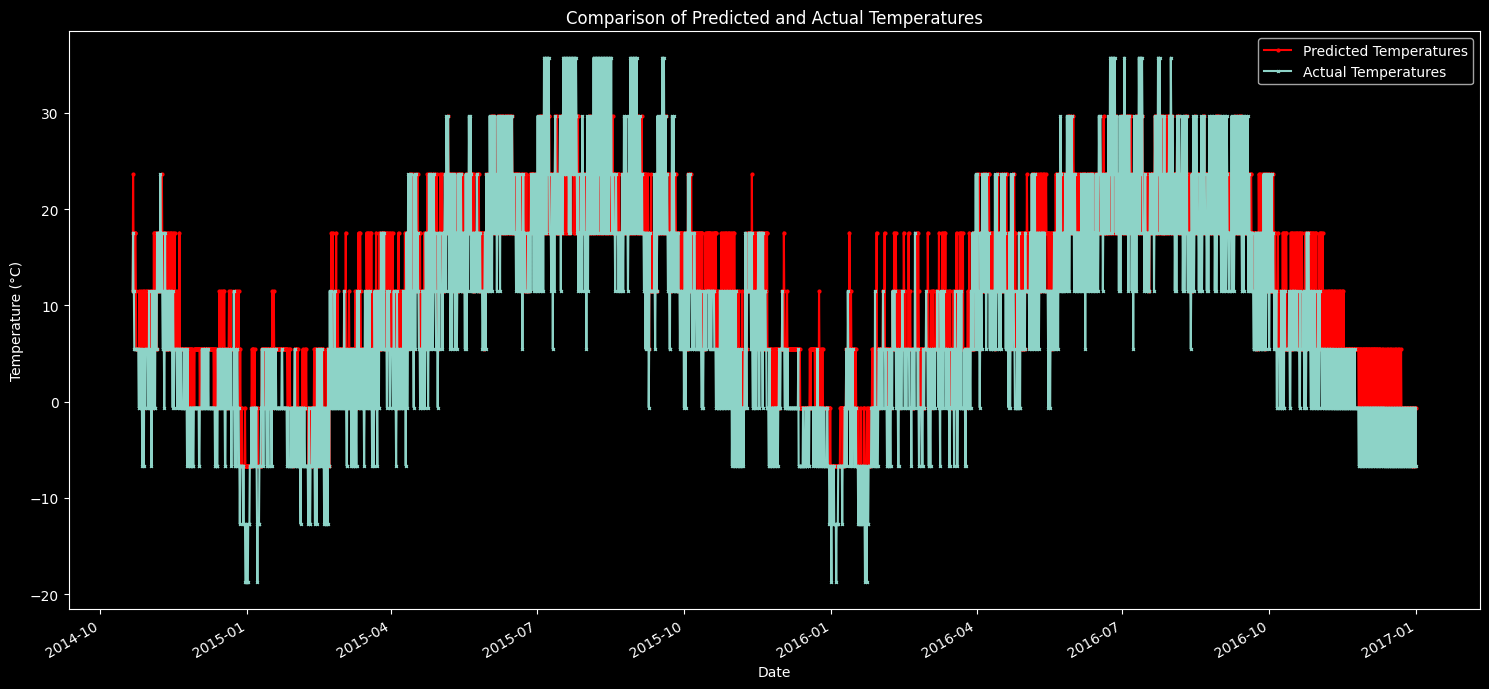

In [59]:
feature_dim = X_train.shape[1]
model = LSTMTemperatureCRFClassifier(feature_dim, num_bins, 64, 3)
optimizer = optim.Adam(model.parameters(), lr=0.01)

metrics = train_and_evaluate(model, train_loader, test_loader, optimizer, epochs=50, patience=10)

In [60]:
def hyperparameter_search_lstm(train_loader, test_loader):
    feature_dim = X_train.shape[1]
    num_classes = num_bins

    hidden_dim_options = [32, 64, 128]
    num_layers_options = [1, 2, 3]
    lr_options = [0.0001, 0.001, 0.01]
    batch_size_options = [16, 32, 64]

    results = []

    for hidden_dim, num_layers, lr, batch_size in product(hidden_dim_options, num_layers_options, lr_options, batch_size_options):
        print(f'Testing configuration: hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}, batch_size={batch_size}')
        
        model = LSTMTemperatureCRFClassifier(feature_dim, num_classes, hidden_dim, num_layers)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        metrics = train_and_evaluate(model, train_loader, test_loader, optimizer, epochs=50, patience=10, plot=False, print_results=False)
        
        results.append({
            'hidden_dim': hidden_dim,
            'num_layers': num_layers,
            'lr': lr,
            'batch_size': batch_size,
            'train_loss': metrics['train_loss'][-1],
            'train_accuracy': metrics['train_accuracy'][-1],
            'train_f_score': metrics['train_f_score'][-1],
            'test_loss': metrics['test_loss'][-1],
            'test_accuracy': metrics['test_accuracy'][-1],
            'test_f_score': metrics['test_f_score'][-1],
            'mae': metrics['mae'][-1]
        })
        print(f"Test Loss: {metrics['test_loss'][-1]:.4f}, Test Accuracy: {metrics['test_accuracy'][-1]:.4f}, Test F1 Score: {metrics['test_f_score'][-1]:.4f}, MAE: {metrics['mae'][-1]:.2f}")

    results_df = pd.DataFrame(results)
    results_df.to_csv('lstm_hyperparameter_search_results.csv', index=False)
    print("LSTM Hyperparameter search results saved to 'lstm_hyperparameter_search_results.csv'")
    return results_df

lstm_results_df = hyperparameter_search_lstm(train_loader, test_loader)

Testing configuration: hidden_dim=32, num_layers=1, lr=0.0001, batch_size=16
Test Loss: 1.4086, Test Accuracy: 0.3778, Test F1 Score: 0.1169, MAE: 4.27
Testing configuration: hidden_dim=32, num_layers=1, lr=0.0001, batch_size=32
Test Loss: 1.4062, Test Accuracy: 0.3846, Test F1 Score: 0.1169, MAE: 4.23
Testing configuration: hidden_dim=32, num_layers=1, lr=0.0001, batch_size=64
Test Loss: 1.4026, Test Accuracy: 0.3790, Test F1 Score: 0.1169, MAE: 4.27
Testing configuration: hidden_dim=32, num_layers=1, lr=0.001, batch_size=16
Test Loss: 1.4282, Test Accuracy: 0.3740, Test F1 Score: 0.1169, MAE: 4.31
Testing configuration: hidden_dim=32, num_layers=1, lr=0.001, batch_size=32
Test Loss: 1.4485, Test Accuracy: 0.3803, Test F1 Score: 0.1169, MAE: 4.26
Testing configuration: hidden_dim=32, num_layers=1, lr=0.001, batch_size=64
Test Loss: 1.4484, Test Accuracy: 0.3837, Test F1 Score: 0.1169, MAE: 4.23
Testing configuration: hidden_dim=32, num_layers=1, lr=0.01, batch_size=16
Test Loss: 1.427

In [61]:
print("Top 5 configurations for LSTM (test loss):")
print(lstm_results_df.nsmallest(5, 'test_loss'))

print("Top 5 configurations for MLP (f1 score):")
print(lstm_results_df.nlargest(5, 'test_f_score'))

print("Top 5 configurations for LSTM (mae):")
print(lstm_results_df.nsmallest(5, 'mae'))

Top 5 configurations for LSTM (test loss):
    hidden_dim  num_layers      lr  batch_size  train_loss  train_accuracy  \
43          64           2  0.0100          32    0.936671        0.476190   
78         128           3  0.0100          16    0.884461        0.476190   
35          64           1  0.0100          64    1.126934        0.476190   
61         128           1  0.0100          32    1.162922        0.476190   
38          64           2  0.0001          64    0.951771        0.714286   

    train_f_score  test_loss  test_accuracy  test_f_score       mae  
43       0.529915   1.376692       0.429150      0.000000  3.854970  
78       0.457271   1.377408       0.465276      0.000000  3.664392  
35       0.457271   1.377941       0.428527      0.116883  3.813458  
61       0.529915   1.379518       0.434444      0.116883  3.864405  
38       0.654195   1.383664       0.384304      0.116883  4.198389  
Top 5 configurations for MLP (f1 score):
    hidden_dim  num_layers 